**GAN distillation Approach**

In [2]:
import numpy as np 
import pandas as pd 
import os

In [2]:
try: 
    from astra.torch.models import AlexNetClassifier
except:
    %pip install git+https://github.com/sustainability-lab/ASTRA

/home/project/anaconda3/envs/to113/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import umap
import math
from torchvision.utils import save_image
from torch.autograd import Variable
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torchvision.utils as vutils

/home/project/anaconda3/envs/to113/lib/python3.10/site-packages/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/project/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [4]:
# Specify the GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")
print(f"Current CUDA device: {torch.cuda.current_device()}")
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
os.makedirs("images", exist_ok=True)

Using device: cuda
Current CUDA device: 0
Using GPU: Quadro RTX 5000


In [5]:
tf = transforms.Compose([transforms.Resize(64),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                        ])

dataset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True,
                                     transform = tf)

print(len(dataset))
print(dataset[0][0].shape)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'fake')

Files already downloaded and verified
50000
torch.Size([3, 64, 64])


In [8]:
# Verifying the first image to ensure the transformation worked
first_image, first_label = dataset[0]
print(first_image.shape)  

n_train= math.floor(50000*(0.20))
n_validation= math.floor(50000*(0.10))

# Convert the entire dataset to a tensor format
X_tensor = torch.stack([dataset[i][0] for i in range(len(dataset))])
y_tensor = torch.tensor([dataset[i][1] for i in range(len(dataset))])

print(X_tensor.shape, X_tensor.dtype)  
print(y_tensor.shape, y_tensor.dtype)  

torch.Size([3, 64, 64])
torch.Size([50000, 3, 64, 64]) torch.float32
torch.Size([50000]) torch.int64


In [7]:
n_classes= torch.unique(y_tensor)
print(n_classes)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [9]:
torch.manual_seed(0)
idx= torch.randperm(len(X_tensor))
train_idx= idx[:n_train]
validation_idx= idx[n_train:(n_train+n_validation)]
print(len(train_idx),len(validation_idx))

10000 5000


In [9]:
# from alexnet_pytorch import AlexNet
from astra.torch.models import AlexNetClassifier
classifier= AlexNetClassifier(models.alexnet, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)


**Function to classify Hard samples**

In [10]:
def classify_samples(net, X_tensor, y_tensor, idx, threshold=0.6):
    hard_samples = []
    easy_samples = []
    
    with torch.no_grad():
        X_dataset = X_tensor[idx].to(device)
        y_dataset = y_tensor[idx].to(device)
        outputs = net(X_dataset)
        _, predicted = torch.max(outputs, 0)
        confidence = torch.max(F.softmax(outputs, dim=1), 1)[0]
        
        for i in range(len(X_dataset)):
            if predicted[i] != y_dataset[i] or confidence[i] < threshold:  # Threshold for hard samples
                hard_samples.append((X_dataset[i].cpu(), y_dataset[i].cpu()))
            else:
                easy_samples.append((X_dataset[i].cpu(), y_dataset[i].cpu()))
    
    return easy_samples, hard_samples

def naive_accuracy(net,X,y):
    with torch.no_grad():
        logits_pred= net(X)
        y_pred= logits_pred.argmax(dim=1)
        acc= (y_pred==y).float().mean()
        return y_pred, acc

def predict(net, classes):
    for i, (name, idx) in enumerate(zip(["validation"], [validation_idx])):
        X_dataset= X_tensor[idx].to(device)
        y_dataset= y_tensor[idx].to(device)
        y_pred,acc= naive_accuracy(net, X_dataset, y_dataset)
        print(f'{name} accuracy: {acc*100:.2f}%')


**Embeddings obtained before training**

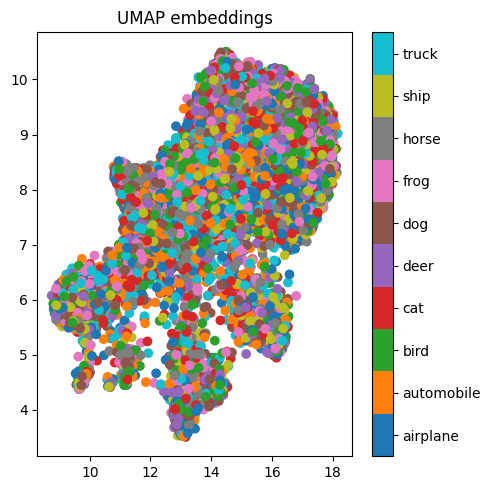

In [30]:
def viz_embeddings(net, X, y, device):
    reducer= umap.UMAP()
    with torch.no_grad():
        emb= net.featurizer(X.to(device))
    emb= emb.cpu().numpy()
    emb= reducer.fit_transform(emb)
    plt.figure(figsize=(5,5))
    plt.scatter(emb[:,0], emb[:,1], c=y.cpu().numpy(), cmap='tab10')
    cb= plt.colorbar(boundaries= np.arange(11)-0.5)
    cb.set_ticks(np.arange(10))
    cb.set_ticklabels(dataset.classes)
    plt.title("UMAP embeddings")
    plt.tight_layout()
    
viz_embeddings(classifier, X[train_idx], y[train_idx], device)

In [48]:
import pickle
# Load the entire model
with open('classifier.pkl', 'rb') as f:
    classifier = pickle.load(f)

**Training on real data**

In [11]:
iter_losses, epoch_losses = train_fn(classifier, loss_fn= nn.CrossEntropyLoss(), input= X_tensor[train_idx], output= y_tensor[train_idx], lr=3e-4, epochs=30, batch_size=128)

  0%|          | 0/30 [00:00<?, ?it/s]

Loss: 0.13688111: 100%|██████████| 30/30 [02:00<00:00,  4.00s/it]


In [13]:
import pickle
with open('classifier.pkl', 'wb') as f:
    pickle.dump(classifier, f)

**Accuracy obtained on real data**

In [49]:
predict(classifier, dataset.classes)

validation accuracy: 56.04%


**Training the ACGAN model on trainset**

In [13]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    
    def __init__(self):
        super(Generator,self).__init__()
        
        #input 100*1*1
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(100,512,4,1,0,bias = False),
                                   nn.ReLU(True))

        #input 512*4*4
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(512,256,4,2,1,bias = False),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(True))
        #input 256*8*8
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(256,128,4,2,1,bias = False),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(True))
        #input 128*16*16
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(128,64,4,2,1,bias = False),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(True))
        #input 64*32*32
        self.layer5 = nn.Sequential(nn.ConvTranspose2d(64,3,4,2,1,bias = False),
                                   nn.Tanh())
        #output 3*64*64
      
        self.embedding = nn.Embedding(10,100)
        
        
    def forward(self,noise,label):
        
        label_embedding = self.embedding(label)
        x = torch.mul(noise,label_embedding)
        x = x.view(-1,100,1,1)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x


**Discriminator**

In [14]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator,self).__init__()        
        
        #input 3*64*64
        self.layer1 = nn.Sequential(nn.Conv2d(3,64,4,2,1,bias = False),
                                    nn.BatchNorm2d(64),
                                   nn.LeakyReLU(0.2,True),
                                   nn.Dropout2d(0.5))
        
        #input 64*32*32
        self.layer2 = nn.Sequential(nn.Conv2d(64,128,4,2,1,bias = False),
                                    nn.BatchNorm2d(128),
                                   nn.LeakyReLU(0.2,True),
                                   nn.Dropout2d(0.5))
        #input 128*16*16
        self.layer3 = nn.Sequential(nn.Conv2d(128,256,4,2,1,bias = False),
                                    nn.BatchNorm2d(256),
                                   nn.LeakyReLU(0.2,True),
                                   nn.Dropout2d(0.5))
        #input 256*8*8
        self.layer4 = nn.Sequential(nn.Conv2d(256,512,4,2,1,bias = False),
                                    nn.BatchNorm2d(512),
                                   nn.LeakyReLU(0.2,True))
        #input 512*4*4
        self.validity_layer = nn.Sequential(nn.Conv2d(512,1,4,1,0,bias = False),
                                   nn.Sigmoid())
        
        self.label_layer = nn.Sequential(nn.Conv2d(512,11,4,1,0,bias = False),
                                   nn.LogSoftmax(dim = 1))
        
    def forward(self,x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        validity = self.validity_layer(x)
        plabel = self.label_layer(x)
        
        validity = validity.view(-1)
        plabel = plabel.view(-1,11)
        
        return validity,plabel
    
gen = Generator().to(device)
gen.apply(weights_init)

disc = Discriminator().to(device)
disc.apply(weights_init)

paramsG = list(gen.parameters())
print(len(paramsG))

paramsD = list(disc.parameters())
print(len(paramsD))        
        
optimG = optim.Adam(gen.parameters(), 0.0002, betas = (0.5,0.999))
optimD = optim.Adam(disc.parameters(), 0.0002, betas = (0.5,0.999))
optimC = optim.Adam(classifier.parameters(), 0.0002, betas = (0.5,0.999))

validity_loss = nn.BCELoss()

12
14


In [10]:
from torch.utils.data import DataLoader, Subset
# Create a subset of the dataset
train_subset = Subset(dataset, train_idx)

# Create a DataLoader for the training subset
trainloader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)

torch.Size([64, 3, 64, 64])


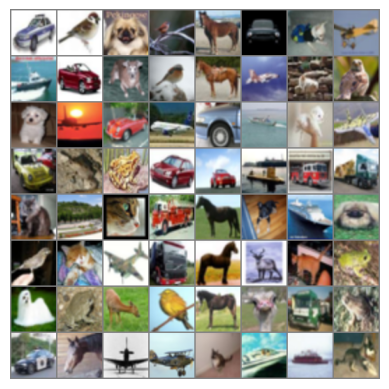

In [16]:
def showImage(images,epoch=-99, idx = -99):
    images = images.cpu().numpy()
    images = images/2 + 0.5
    plt.imshow(np.transpose(images,axes = (1,2,0)))
    plt.axis('off')
    if epoch!=-99:
        plt.savefig("e" + str(epoch) + "i" + str(idx) + ".png")

dataiter = iter(trainloader)
images,labels = next(dataiter)
print(images.size())
showImage(torchvision.utils.make_grid(images[0:64]))

In [17]:
# Define epsilon value
epsilon = 1e-5

def check_and_correct(tensor, name):
    if torch.isnan(tensor).any() or (tensor == 0).any():
        print(f"NaN or zero detected in {name}, adding epsilon to correct.")
        tensor = torch.abs(tensor + epsilon)
        
    return tensor

**GAN training**

In [32]:
import pickle
# Load the entire model
with open('gen.pkl', 'rb') as f:
    gen = pickle.load(f)
    
with open('disc.pkl', 'rb') as f:
    disc = pickle.load(f)

# If using GPU
gen.to(device)
disc.to(device)

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout2d(p=0.5, inplace=False)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), pa

[1/100] [0/157] D_x: [0.5615] D_G: [0.4247/0.4547] G_loss: [2.4183] D_loss: [3.5393] D_label: [3.4974] 
[1/100] [1/157] D_x: [0.5109] D_G: [0.4704/0.4119] G_loss: [2.8450] D_loss: [3.4317] D_label: [3.9776] 
[1/100] [2/157] D_x: [0.5165] D_G: [0.3837/0.5006] G_loss: [2.0178] D_loss: [2.9091] D_label: [3.0243] 
[1/100] [3/157] D_x: [0.5699] D_G: [0.4525/0.4564] G_loss: [2.4831] D_loss: [3.1316] D_label: [3.5255] 
[1/100] [4/157] D_x: [0.5123] D_G: [0.4678/0.4122] G_loss: [2.6626] D_loss: [3.1652] D_label: [3.5533] 
[1/100] [5/157] D_x: [0.5368] D_G: [0.4455/0.5326] G_loss: [1.8096] D_loss: [3.3381] D_label: [3.2174] 
[1/100] [6/157] D_x: [0.5035] D_G: [0.4475/0.4874] G_loss: [2.2364] D_loss: [3.5246] D_label: [3.6289] 
[1/100] [7/157] D_x: [0.5584] D_G: [0.4238/0.4797] G_loss: [2.4183] D_loss: [3.0288] D_label: [3.5066] 
[1/100] [8/157] D_x: [0.4845] D_G: [0.4569/0.4369] G_loss: [2.6251] D_loss: [3.6483] D_label: [4.0423] 
[1/100] [9/157] D_x: [0.5618] D_G: [0.4995/0.4687] G_loss: [2.45

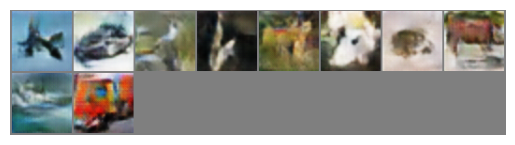

In [34]:
real_labels = 0.7 + 0.3 * torch.rand(10, device = device)
fake_labels = 0.3 * torch.rand(10, device = device)
epochs = 100

for epoch in range(1,epochs+1):
    
    for idx, (images,labels) in enumerate(trainloader,0):
        
        batch_size = images.size(0)
        labels= labels.to(device)
        images = images.to(device)
        
        real_label = real_labels[idx % 10]
        fake_label = fake_labels[idx % 10]
        
        fake_class_labels = 10*torch.ones((batch_size,),dtype = torch.long,device = device)
        
        if idx % 25 == 0:
            real_label, fake_label = fake_label, real_label
        
        # ---------------------
        #         disc
        # ---------------------
        
        optimD.zero_grad()       
        
        # real
        validity_label = torch.full((batch_size,),real_label , device = device)
   
        pvalidity, plabels = disc(images)    
    
        pvalidity = check_and_correct(pvalidity, "pvalidity (real)")
        plabels = check_and_correct(plabels, "plabels (real)")
        
        errD_real_val = validity_loss(pvalidity, validity_label)            
        errD_real_label = F.nll_loss(plabels,labels)
        
        errD_real = errD_real_val + errD_real_label
        if errD_real==0:
            errD_real+= 10**(-5)
        errD_real.backward()
        
        D_x = pvalidity.mean().item()        
        
        #fake 
        noise = torch.randn(batch_size,100,device = device)  
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        
        fakes = gen(noise,sample_labels)
        
        validity_label.fill_(fake_label)
        
        pvalidity, plabels = disc(fakes.detach())     
        
        pvalidity = check_and_correct(pvalidity, "pvalidity (fake)")
        plabels = check_and_correct(plabels, "plabels (fake)")
        
        errD_fake_val = validity_loss(pvalidity, validity_label)
        errD_fake_label = F.nll_loss(plabels, fake_class_labels)
        
        errD_fake = errD_fake_val + errD_fake_label
        if errD_fake==0:
            errD_fake+= 10**(-5)
        errD_fake.backward()
        
        D_G_z1 = pvalidity.mean().item()
        
        #finally update the params!
        errD = errD_real + errD_fake
        
        optimD.step()
    
        
        # ------------------------
        #      gen
        # ------------------------
        
        
        optimG.zero_grad()
        
        noise = torch.randn(batch_size,100,device = device)  
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        
        validity_label.fill_(1)
        
        fakes = gen(noise,sample_labels)
        pvalidity,plabels = disc(fakes)
        
        pvalidity = check_and_correct(pvalidity, "pvalidity (gen)")
        plabels = check_and_correct(plabels, "plabels (gen)")
        
        errG_val = validity_loss(pvalidity, validity_label)        
        errG_label = F.nll_loss(plabels, sample_labels)
        
        errG = errG_val + errG_label
        if errG==0:
            errG+= 10**(-5)
        errG.backward()
        
        D_G_z2 = pvalidity.mean().item()
        
        optimG.step()
        
        
        print("[{}/{}] [{}/{}] D_x: [{:.4f}] D_G: [{:.4f}/{:.4f}] G_loss: [{:.4f}] D_loss: [{:.4f}] D_label: [{:.4f}] "
              .format(epoch,epochs, idx, len(trainloader),D_x, D_G_z1,D_G_z2,errG,errD,
                      errD_real_label + errD_fake_label + errG_label))
        
        
    if epoch%20==0:
        noise = torch.randn(10,100,device = device)  
        labels = torch.arange(0,10,dtype = torch.long,device = device)

        gen_images = gen(noise,labels).detach()

        showImage(torchvision.utils.make_grid(gen_images),epoch,idx)

In [23]:
with open('gen.pkl', 'wb') as f:
    pickle.dump(gen, f)

with open('disc.pkl', 'wb') as f:
    pickle.dump(disc,f)

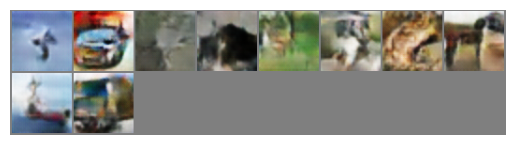

In [35]:
noise = torch.randn(10,100,device = device)  
labels = torch.arange(0,10,dtype = torch.long,device = device)

gen_images = gen(noise,labels).detach()

showImage(torchvision.utils.make_grid(gen_images),1,1)

**GAN distillation**

In [36]:
def classify_samples(net, X_tensor, y_tensor, idx, threshold=0.6):
    hard_samples = []
    easy_samples = []
    
    with torch.no_grad():
        X_dataset = X_tensor[idx].to(device)
        y_dataset = y_tensor[idx].to(device)
        outputs = net(X_dataset)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.max(F.softmax(outputs, dim=1), 1)[0]
        
        for i in range(len(X_dataset)):
            if predicted[i] != y_dataset[i] or confidence[i] < threshold:  # Threshold for hard samples
                hard_samples.append((X_dataset[i].cpu(), y_dataset[i].cpu()))
            else:
                easy_samples.append((X_dataset[i].cpu(), y_dataset[i].cpu()))
    
    return easy_samples, hard_samples


In [37]:
easy_samples, hard_samples= classify_samples(classifier, X_tensor, y_tensor, train_idx, threshold=0.6)

**Visualizing the Hard samples**

Visualizing Hard Samples


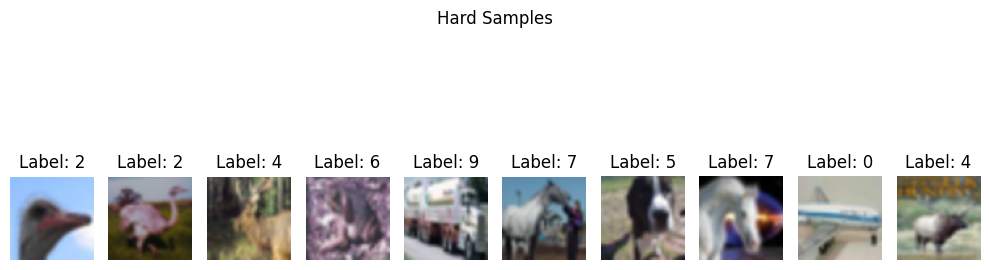

In [45]:
def visualize_samples(samples, title, num_samples=10):
    plt.figure(figsize=(10,4))
    for i, (image, label) in enumerate(samples[:num_samples]):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)  # Assuming the images are normalized
        plt.title(f'Label: {label.item()}')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

num_samples_to_show = 10

print("Visualizing Hard Samples")
visualize_samples(hard_samples, title="Hard Samples", num_samples=num_samples_to_show)

**Distillation Loss function**

In [47]:
def distillation_loss(generator, generated_images, feature_extractor, hard_samples, easy_samples, margin=1.0):
    G_loss = 0

    # Extract features for the entire batch of generated images
    F_generated = feature_extractor(generated_images).detach()

    hard_sample_images = torch.stack([hs[0] for hs in hard_samples]).to(device)
    easy_sample_images = torch.stack([es[0] for es in easy_samples[:len(hard_samples)]]).to(device)

    # Ensure the images are on the correct device and batched
    F_hard = feature_extractor(hard_sample_images).detach()
    F_easy = feature_extractor(easy_sample_images).detach()

    # Compute distillation loss for the entire batch
    dist_loss = torch.max(
        torch.tensor(0.0, device=device),
        torch.norm(F_generated.unsqueeze(1) - F_hard, dim=2) -
        torch.norm(F_generated.unsqueeze(1) - F_easy, dim=2) + margin
    ).mean()

    G_loss += dist_loss

    return G_loss


In [50]:
# feature_extractor.featurizer.load_state_dict(classifier.featurizer.state_dict())
feature_extractor = classifier.featurizer
# feature_extractor = torch.nn.Sequential(*list(classifier.children())[:-1])
feature_extractor.load_state_dict(classifier.featurizer.state_dict())
feature_extractor.to(device)

AlexNet(
  (alexnet): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (

In [51]:
noise = torch.randn(batch_size,100,device = device)  
sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)

validity_label.fill_(1)

fakes = gen(noise,sample_labels)

dist_loss = distillation_loss(gen, fakes, feature_extractor, hard_samples, easy_samples)

In [30]:

# Convert samples to a list of tuples for easier batching
samples = hard_samples + easy_samples

# Define batch size
batch_size = 64

# Iterate over samples in batches
for i in range(0, len(samples), batch_size):
    batch_samples = samples[i:i + batch_size]
    
    # Prepare lists for batch processing
    xi_list, yi_list = [], []

    for xi, yi in batch_samples:
        xi_list.append(xi)
        yi_list.append(yi)

    # Convert lists to tensors and move to device
    xi = torch.stack(xi_list).to(device)
    yi = torch.stack(yi_list).to(device)

    # Generate fake images for the same labels in the batch
    noise = torch.randn(len(yi), 100, device=device)
    xg = gen(noise, yi).detach()

    # Concatenate real and fake images, and their labels
    x = torch.cat([xg, xi], dim=0)
    y = torch.cat([yi, yi], dim=0)

    # Perform optimization step
    optimC.zero_grad()
    output = classifier(x)
    loss_C = F.cross_entropy(output, y)
    loss_C.backward()
    optimC.step()

feature_extractor.load_state_dict(classifier.featurizer.state_dict())

0
100


<All keys matched successfully>

In [ ]:
with open('gen_distillation.pkl', 'rb') as f:
    gen = pickle.load(f)
    
with open('disc_distillation.pkl', 'rb') as f:
    disc = pickle.load(f)

# If using GPU
gen.to(device)
disc.to(device)

**Distillation loop**

[1/100] [0/157] D_x: [0.5172] D_G: [0.5162/0.4600] G_loss: [5.8062] D_loss: [3.5278] D_label: [3.6186] 
[1/100] [1/157] D_x: [0.5335] D_G: [0.4745/0.4952] G_loss: [5.3902] D_loss: [3.2319] D_label: [3.2796] 
[1/100] [2/157] D_x: [0.5443] D_G: [0.4771/0.4431] G_loss: [6.0041] D_loss: [3.1200] D_label: [3.5644] 
[1/100] [3/157] D_x: [0.5455] D_G: [0.4542/0.4825] G_loss: [5.4163] D_loss: [3.2083] D_label: [3.3600] 
[1/100] [4/157] D_x: [0.5066] D_G: [0.4572/0.4886] G_loss: [5.5121] D_loss: [3.5672] D_label: [3.5634] 
[1/100] [5/157] D_x: [0.5908] D_G: [0.4807/0.4518] G_loss: [5.8877] D_loss: [2.8303] D_label: [3.1263] 
[1/100] [6/157] D_x: [0.5023] D_G: [0.4349/0.4327] G_loss: [6.3041] D_loss: [3.2948] D_label: [3.6870] 
[1/100] [7/157] D_x: [0.5013] D_G: [0.4655/0.4234] G_loss: [5.5442] D_loss: [3.4261] D_label: [3.6456] 
[1/100] [8/157] D_x: [0.5027] D_G: [0.4571/0.4765] G_loss: [5.4916] D_loss: [3.2947] D_label: [3.3842] 
[1/100] [9/157] D_x: [0.5040] D_G: [0.4798/0.4448] G_loss: [5.78

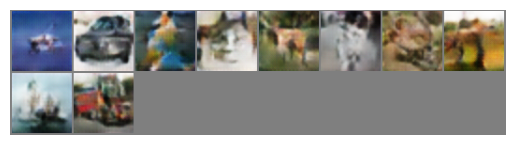

In [52]:
real_labels = 0.7 + 0.3 * torch.rand(10, device = device)
fake_labels = 0.3 * torch.rand(10, device = device)
epochs = 100

for epoch in range(1,epochs+1):
    
    for idx, (images,labels) in enumerate(trainloader,0):
        
        batch_size = images.size(0)
        labels= labels.to(device)
        images = images.to(device)
        
        real_label = real_labels[idx % 10]
        fake_label = fake_labels[idx % 10]
        
        fake_class_labels = 10*torch.ones((batch_size,),dtype = torch.long,device = device)
        
        if idx % 25 == 0:
            real_label, fake_label = fake_label, real_label
        
        # ---------------------
        #         disc
        # ---------------------
        
        optimD.zero_grad()       
        
        # real
        validity_label = torch.full((batch_size,),real_label , device = device)
   
        pvalidity, plabels = disc(images)    
    
        pvalidity = check_and_correct(pvalidity, "pvalidity (real)")
        plabels = check_and_correct(plabels, "plabels (real)")
        
        errD_real_val = validity_loss(pvalidity, validity_label)            
        errD_real_label = F.nll_loss(plabels,labels)
        
        errD_real = errD_real_val + errD_real_label
        if errD_real==0:
            errD_real+= 10**(-5)
        errD_real.backward()
        
        D_x = pvalidity.mean().item()        
        
        #fake 
        noise = torch.randn(batch_size,100,device = device)  
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        
        fakes = gen(noise,sample_labels)
        
        validity_label.fill_(fake_label)
        
        pvalidity, plabels = disc(fakes.detach())     
        
        pvalidity = check_and_correct(pvalidity, "pvalidity (fake)")
        plabels = check_and_correct(plabels, "plabels (fake)")
        
        errD_fake_val = validity_loss(pvalidity, validity_label)
        errD_fake_label = F.nll_loss(plabels, fake_class_labels)
        
        errD_fake = errD_fake_val + errD_fake_label
        if errD_fake==0:
            errD_fake+= 10**(-5)
        errD_fake.backward()
        
        D_G_z1 = pvalidity.mean().item()
        
        #finally update the params!
        errD = errD_real + errD_fake
        
        optimD.step()
    
        
        # ------------------------
        #      gen
        # ------------------------
        
        
        optimG.zero_grad()
        
        noise = torch.randn(batch_size,100,device = device)  
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        
        validity_label.fill_(1)
        
        fakes = gen(noise,sample_labels)
        pvalidity,plabels = disc(fakes)
        
        pvalidity = check_and_correct(pvalidity, "pvalidity (gen)")
        plabels = check_and_correct(plabels, "plabels (gen)")
        
        errG_val = validity_loss(pvalidity, validity_label)        
        errG_label = F.nll_loss(plabels, sample_labels)
        errG = errG_val + errG_label
        
        dist_loss = distillation_loss(gen, fakes, feature_extractor, hard_samples, easy_samples)
        G_loss_with_distillation = errG + dist_loss
        if G_loss_with_distillation==0:
            G_loss_with_distillation+= 10**(-5)
        G_loss_with_distillation.backward()
        
        D_G_z2 = pvalidity.mean().item()
        
        optimG.step()
        
        print("[{}/{}] [{}/{}] D_x: [{:.4f}] D_G: [{:.4f}/{:.4f}] G_loss: [{:.4f}] D_loss: [{:.4f}] D_label: [{:.4f}] "
              .format(epoch,epochs, idx, len(trainloader),D_x, D_G_z1,D_G_z2,G_loss_with_distillation,errD,
                      errD_real_label + errD_fake_label + errG_label))
        
        
    # ---------------------
    #  Train Classifier
    # ---------------------
    
    # Convert samples to a list of tuples for easier batching
    samples = hard_samples + easy_samples

    # Define batch size
    batch_size = 64

    # Iterate over samples in batches
    for i in range(0, len(samples), batch_size):
        batch_samples = samples[i:i + batch_size]
        
        # Prepare lists for batch processing
        xi_list, yi_list = [], []

        for xi, yi in batch_samples:
            xi_list.append(xi)
            yi_list.append(yi)

        # Convert lists to tensors and move to device
        xi = torch.stack(xi_list).to(device)
        yi = torch.stack(yi_list).to(device)

        # Generate fake images for the same labels in the batch
        noise = torch.randn(len(yi), 100, device=device)
        xg = gen(noise, yi).detach()

        # Concatenate real and fake images, and their labels
        x = torch.cat([xg, xi], dim=0)
        y = torch.cat([yi, yi], dim=0)

        # Perform optimization step
        optimC.zero_grad()
        output = classifier(x)
        loss_C = F.cross_entropy(output, y)
        loss_C.backward()
        optimC.step()

    feature_extractor.load_state_dict(classifier.featurizer.state_dict())

    if epoch%20==0:
        noise = torch.randn(10,100,device = device)  
        labels = torch.arange(0,10,dtype = torch.long,device = device)

        gen_images = gen(noise,labels).detach()

        showImage(torchvision.utils.make_grid(gen_images),epoch,idx)


In [73]:
with open('gen_distillation.pkl', 'wb') as f:
    pickle.dump(gen, f)

with open('disc_distillation.pkl', 'wb') as f:
    pickle.dump(disc,f)

**Accuracy after Gan-distillation**

In [63]:
classifier_final= AlexNetClassifier(models.alexnet, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)

In [64]:
distillation_augmented = []
y_augmented = []

# Ensure y_tensor is on the same device as noise and gen
y_tensor_2 = y_tensor.to(device)

for i in range(5000):
    noise = torch.randn(1,100,device = device)  
    xg = gen(noise, y_tensor_2[i].unsqueeze(0)).detach()
    distillation_augmented.append(xg)
    y_augmented.append(y_tensor_2[i].unsqueeze(0))

distillation_augmented = torch.cat(distillation_augmented, dim=0)
y_augmented = torch.cat(y_augmented, dim=0)

# Assuming X_tensor contains the original data and y_tensor contains the original labels
X_tensor_1 = X_tensor[:5000].to(device)
y_tensor_1 = y_tensor[:5000].to(device)

**Augmenting the data in chunks**

In [65]:
# Define the chunk size
chunk_size = 100

# Function to chunk and interleave the data
def interleave_chunks(original, augmented, chunk_size):
    interleaved = []
    for i in range(0, len(original), chunk_size):
        original_chunk = original[i:i + chunk_size]
        augmented_chunk = augmented[i:i + chunk_size]
        interleaved.extend(original_chunk)
        interleaved.extend(augmented_chunk)
    return torch.stack(interleaved)

# Chunk and interleave the data
X_combined = interleave_chunks(X_tensor_1, distillation_augmented, chunk_size)
y_combined = interleave_chunks(y_tensor_1, y_augmented, chunk_size)

X_combined = X_combined.cpu()
y_combined = y_combined.cpu()

print("Combined X shape:", X_combined.shape)
print("Combined y shape:", y_combined.shape)

Combined X shape: torch.Size([10000, 3, 64, 64])
Combined y shape: torch.Size([10000])


In [26]:
import pickle
# Load the entire model
with open('classifier_final.pkl', 'rb') as f:
    classifier_final = pickle.load(f)

In [66]:
iter_losses, epoch_losses = train_fn(classifier_final, loss_fn= nn.CrossEntropyLoss(), input= X_combined, output= y_combined, lr=3e-4, epochs=30, batch_size=128)

Loss: 0.06498235: 100%|██████████| 30/30 [01:02<00:00,  2.08s/it]


In [75]:
with open('Classifier_final.pkl', 'wb') as f:
    pickle.dump(classifier_final, f)

In [27]:
nu= torch.unique(y_augmented)
print(nu)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


**Accuracy**

In [67]:
predict(classifier_final, dataset.classes)

validation accuracy: 59.86%


**Checking for Collapse**

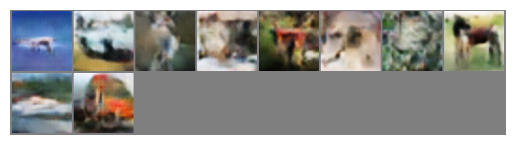

In [68]:
noise = torch.randn(10,100,device = device)  
labels = torch.arange(0,10,dtype = torch.long,device = device)

gen_images = gen(noise,labels).detach()

showImage(torchvision.utils.make_grid(gen_images),1,1)

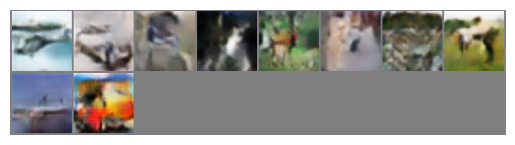

In [69]:
noise = torch.randn(10,100,device = device)  
labels = torch.arange(0,10,dtype = torch.long,device = device)

gen_images = gen(noise,labels).detach()

showImage(torchvision.utils.make_grid(gen_images),1,1)

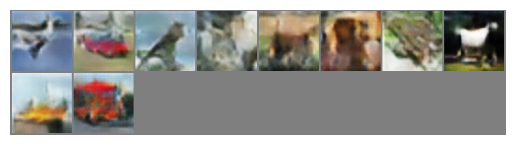

In [70]:
noise = torch.randn(10,100,device = device)  
labels = torch.arange(0,10,dtype = torch.long,device = device)

gen_images = gen(noise,labels).detach()

showImage(torchvision.utils.make_grid(gen_images),1,1)

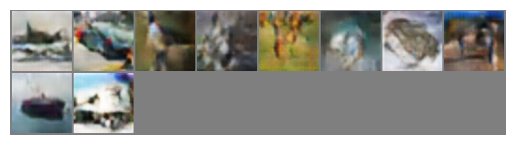

In [71]:
noise = torch.randn(10,100,device = device)  
labels = torch.arange(0,10,dtype = torch.long,device = device)

gen_images = gen(noise,labels).detach()

showImage(torchvision.utils.make_grid(gen_images),1,1)

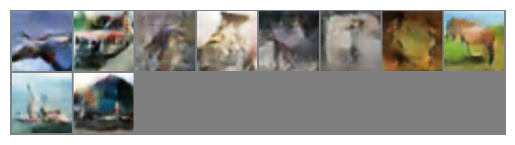

In [72]:
noise = torch.randn(10,100,device = device)  
labels = torch.arange(0,10,dtype = torch.long,device = device)

gen_images = gen(noise,labels).detach()

showImage(torchvision.utils.make_grid(gen_images),1,1)

**Results**

>We used Auxilary-Classifier GAN (AC-GAN) in this method.

>Accuracy with real data:- 56.04%

>Accuracy with Fake data:- 59.86%

>GAN distillation approach is performing better than supervised learning.